In [16]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,\
                   execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
import numpy as np
from scipy import stats as stats
import matplotlib.pyplot as plt

In [5]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
#set marginal probabilities of parents
#pk = P(qk = 1)
p0 = 0.8 
p1 = 0.7

#set conditional probabilities of child
#pkl = P(q2 = 1| q0 = k, q1 = l)
p00 = 0.85
p01 = 0.7
p10 = 0.6
p11 = 0.9

In [7]:
#calculate marginals, for comparison with simulation result
p = \
[(1-p0)*(1-p1)*(1-p00),#000
 p0*(1-p1)*(1-p10),#001, last digit is first cubit!
 (1-p0)*p1*(1-p01),#010
 p0*p1*(1-p11),#011
 (1-p0)*(1-p1)*p00,#100
p0*(1-p1)*p10,#101
(1-p0)*p1*p01,#110
p0*p1*p11]#111

In [8]:
def rot(p):
    return 2*np.arctan(np.sqrt(p/(1-p)))

#determine rotations to match marginal probabilities
theta0 = rot(p0)
theta1 = rot(p1)

#determine conditional rotations to match conditional probabilities
theta00 = rot(p00)
theta01 = rot(p01)
theta10 = rot(p10)
theta11 = rot(p11)

In [9]:
#define Ry-gate with two control qubits
def ccry(theta):
    qc = QuantumCircuit(3)
    qc.cry(theta/2, 1, 2)
    qc.cx(0, 1)
    qc.cry(-theta/2, 1, 2)
    qc.cx(0, 1)
    qc.cry(theta/2, 0, 2)
    gate = qc.to_gate()
    return gate

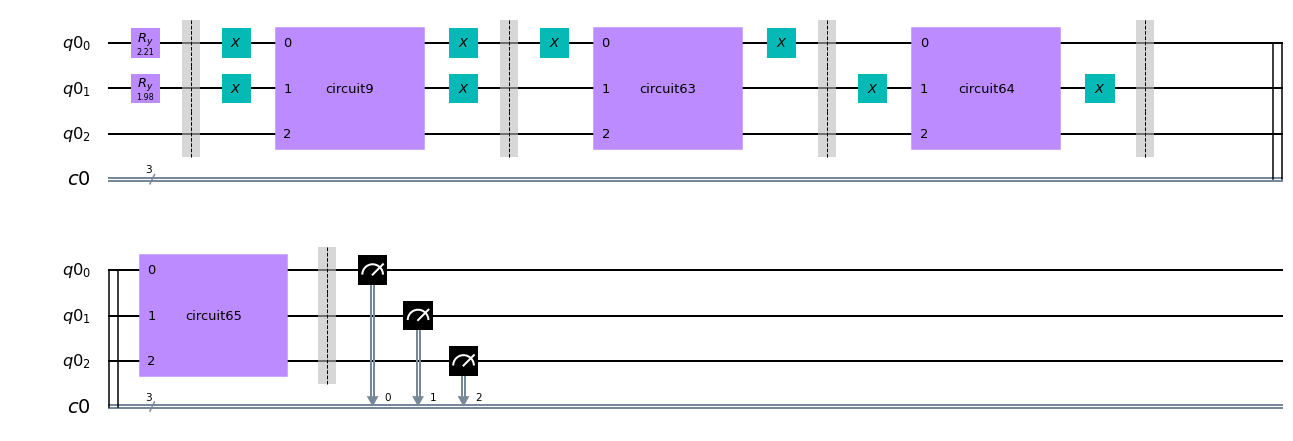

In [10]:
#create cubits and circuit
#one qubit for each node
qreg = QuantumRegister(3)
creg = ClassicalRegister(3)
qc = QuantumCircuit(qreg, creg)

#marginal rotations
qc.ry(theta0, qreg[0])
qc.ry(theta1, qreg[1])
qc.barrier()

#q0 = 0, q1 = 0
qc.x(qreg[0])
qc.x(qreg[1])
qc.append(ccry(theta00), qreg)
qc.x(qreg[0])
qc.x(qreg[1])
qc.barrier()

#q0 = 0, q1 = 1
qc.x(qreg[0])
qc.append(ccry(theta01), qreg)
qc.x(qreg[0])
qc.barrier()

#q0 = 1, q1 = 0
qc.x(qreg[1])
qc.append(ccry(theta10), qreg)
qc.x(qreg[1])
qc.barrier()

#q0 = 1, q1 = 1
qc.append(ccry(theta11), qreg)
qc.barrier()
qc.measure(qreg, creg)
qc.draw('mpl')


In [11]:
#run quantum cirquit
backend = BasicAer.get_backend('qasm_simulator')
nsim = 2**16
counts = execute(qc, backend, shots=nsim).result().get_counts()

#estimate marginal probabilities
bins = list(counts.keys())
bins.sort()
vals = np.array([counts[b] for b in bins])
p_hat = vals / sum(vals)

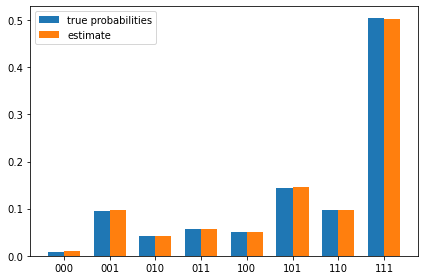

In [32]:
#plot comparisons
x = np.arange(len(bins))  # the label locations
width = 0.35
fig, ax = plt.subplots()
ax.bar(x - width/2, p, width, label='true probabilities')
ax.bar(x + width/2, p_hat, width, label='estimate')
ax.set_xticks(x)
ax.set_xticklabels(bins)
ax.legend()
fig.tight_layout()
plt.show()

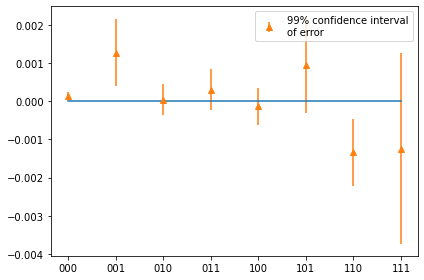

In [37]:
fig, ax = plt.subplots()
ax.plot(x,np.zeros(len(bins)))
ax.errorbar(x, p_hat-p, p_hat*(1-p_hat)/np.sqrt(nsim)*stats.norm.ppf(0.995), linestyle='None', marker='^', label='99% confidence interval\nof error')
ax.set_xticks(x)
ax.set_xticklabels(bins)
ax.legend()
fig.tight_layout()
plt.show()